In [1]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4, data_home="./images")


In [2]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [3]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

# Center data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean

In [4]:
#Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))
#project into PCA subspace
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

(966, 150)
(322, 150)


In [5]:
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
  """Helper function to plot a gallery of portraits"""
  plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
  for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())

In [6]:
def Performance(S, n_samples, n_components):
    explained_variance = (S ** 2) / (n_samples - 1)
    total_var = explained_variance.sum()
    explained_variance_ratio = explained_variance / total_var
    ratio_cumsum = np.cumsum(explained_variance_ratio)
    print(ratio_cumsum.shape)
    eigenvalueCount = np.arange(n_components)
    plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
    plt.title('Compactness')
    plt.show()

In [11]:
def classify_faces(X_transformed, y_train, y_test, X_test_transformed, target_names):
    #build random forest
    estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
    estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]

    predictions = estimator.predict(X_test_transformed)
    correct = predictions==y_test
    total_test = len(X_test_transformed)
    #print("Gnd Truth:", y_test)
    print("Total Testing", total_test)
    print("Predictions", predictions)
    print("Which Correct:",correct)
    print("Total Correct:",np.sum(correct))
    print("Accuracy:",np.sum(correct)/total_test)
    print(classification_report(y_test, predictions, target_names=target_names))


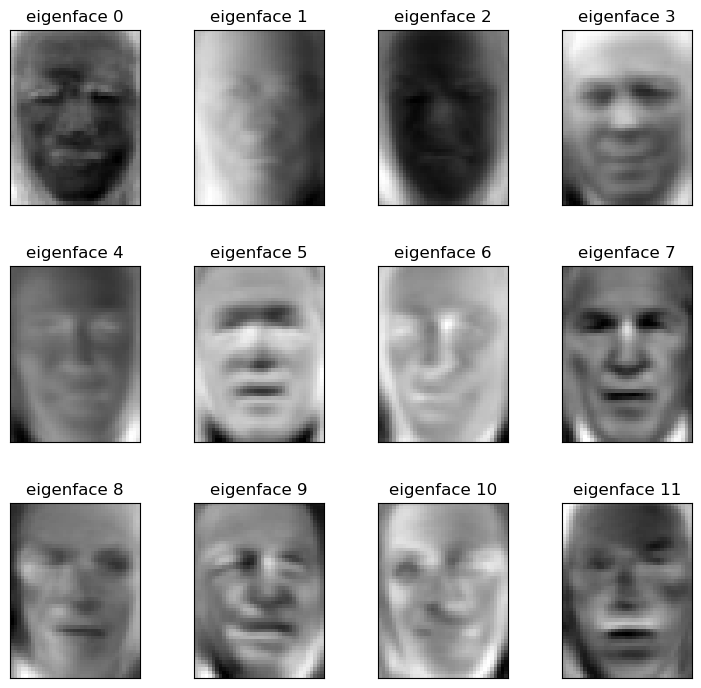

(966,)


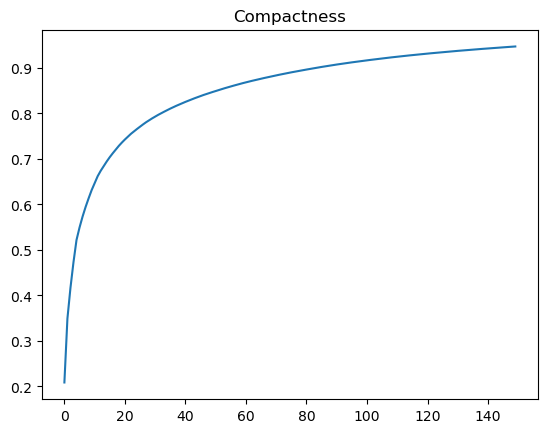

Total Testing 322
Predictions [3 3 6 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 4 1 1 3 3 3 1 4 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 1 3 1 1 3 3 3 4 3 3 3 3 3 1 2 1 3 3 3 6 1 3 3 2 6 3 4 3 3 6 6 3 3
 3 2 3 6 3 3 6 3 3 3 3 3 3 3 3 1 3 6 3 3 1 3 3 1 3 6 3 3 3 3 3 3 3 3 3 1 3
 1 4 3 3 3 1 4 1 3 1 3 3 1 3 4 5 3 1 3 6 6 3 3 3 4 3 3 6 3 3 3 3 1 3 3 3 3
 6 1 1 3 1 3 3 3 6 3 3 3 6 5 5 1 3 3 5 1 3 3 1 3 1 1 5 3 3 3 2 5 3 3 1 3 3
 3 3 3 3 2 4 3 2 3 6 3 3 3 3 3 3 3 3 3 5 1 4 2 4 2 2 4 3 3 3 4 3 3 3 3 3 6
 3 1 1 3 3 3 4 3 3 3 1 3 3 1 1 6 3 3 3 4 1 3 3 3 3 3 1 4 4 3 3 4 3 4 3 1 3
 3 3 3 3 1 3 6 6 1 6 1 6 3 3 3 3 3 3 3 3 3 1 1 3 3 3 1 3 3 3 4 3 3 5 3 3 1
 3 6 3 3 3 6 3 3 1 3 3 3 3 3 3 3 1 3 1 3 3 1 3 3 5 3]
Which Correct: [ True  True  True  True  True  True False  True  True  True  True  True
  True False  True  True  True  True  True  True  True False  True False
 False  True False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False  True
 False  T

c:\Local\Miniconda\envs\Pytorch2\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Local\Miniconda\envs\Pytorch2\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Local\Miniconda\envs\Pytorch2\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

Performance(S, n_samples, n_components)
classify_faces(X_transformed, y_train, y_test, X_test_transformed, target_names)
